## ARMA and ARIMA Models

**Serially correlated.** Best for situations where outcomes of previous days can be used to help determine the outcome of the next day


In [41]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
#import fbprophet
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams

## Reading in the Data

In [42]:
df_orig = pd.read_csv('data/DashboardComm2.csv')
df_orig = df_orig.iloc[:, 0:len(df_orig.columns)-5]

df_orig.columns = df_orig.iloc[0]
#df_orig.head(10)

df = df_orig.iloc[6: ,:]
df = df.rename(columns={"Column1": "Date"})
df.head()

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

filename = 'raw_data_finals\MetalsDashboard(Aug)LATEST.xlsx'
test_df = pd.read_excel(filename, sheet_name="Commodities Data")


### Null Values

In [43]:
print(df.isnull().sum())
print()
print(df.shape)

0
LME Ni cash price                 538
LME Ni inventory (total)          538
LME Ni inventory (briquette)      537
LME Ni inventory (other forms)    537
Critical Inventory                560
LME Co cash price                 538
LME Cu cash price                 538
Comex Cu future                   538
Comex Cu future2                  537
LME Al cash price                 538
Fastmarkets- Cobalt LOW           995
Fastmarkets - Cobalt High         538
Column2                           537
dtype: int64

(1734, 13)


In [44]:
df = df.dropna(subset=["LME Ni cash price"])
df.isnull().sum()

0
LME Ni cash price                   0
LME Ni inventory (total)            0
LME Ni inventory (briquette)        0
LME Ni inventory (other forms)      0
Critical Inventory                 22
LME Co cash price                   0
LME Cu cash price                   0
Comex Cu future                     0
Comex Cu future2                    0
LME Al cash price                   0
Fastmarkets- Cobalt LOW           458
Fastmarkets - Cobalt High           0
Column2                             0
dtype: int64

### Conversion of Ni price from string to number

In [45]:
'''Converts string price to just numbers in string format'''
def convert_price(price_string):
    
    # substitutes any character that is not a numeric digit
    non_digits = re.compile(r'[^\d.]+')
    only_digits = non_digits.sub('', price_string)
    return only_digits

df['LME Ni cash price'] = df['LME Ni cash price'].apply(convert_price)
df['LME Ni cash price'] = pd.to_numeric(df['LME Ni cash price'],errors='coerce')


# Example conversion below
print(convert_price('$5,053 round trip'))

5053


In [46]:
nickel = df.iloc[:, 0]
nickel.head()

Date
2015-01-02    14756
2015-01-05    15126
2015-01-06    15191
2015-01-07    15483
2015-01-08    15486
Name: LME Ni cash price, dtype: int64

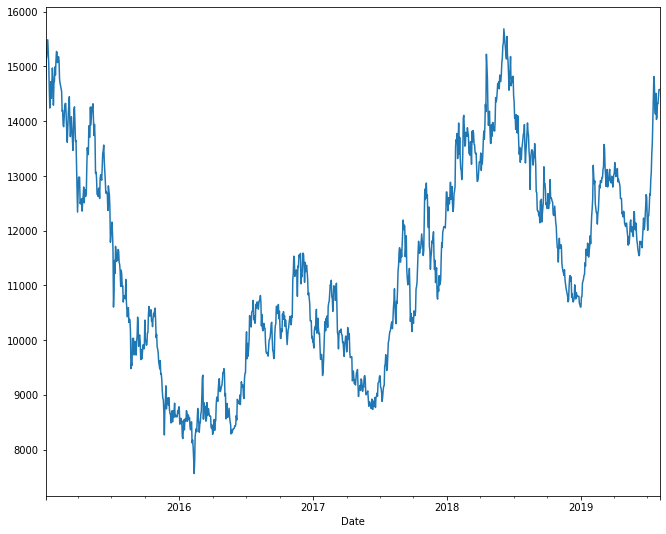

In [47]:
nickel_weekly = nickel.resample('B').sum()
nickel_weekly.plot()

In [60]:
nickel_weekly.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-29', '2019-07-30', '2019-07-31',
               '2019-08-01', '2019-08-02'],
              dtype='datetime64[ns]', name='Date', length=1196, freq='B')

## Time Series Decomposition

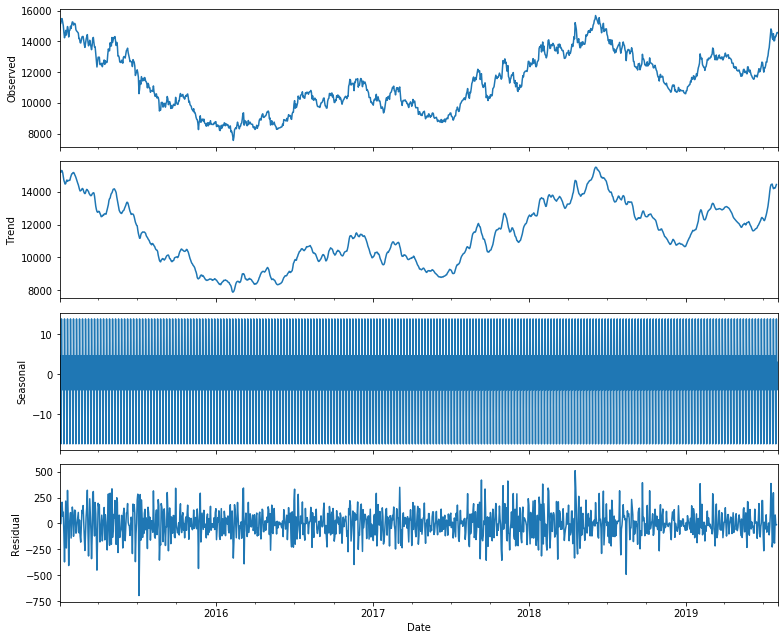

In [30]:
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(nickel_weekly)
fig = decomposition.plot()
plt.show()

In [37]:
print(dir(decomposition))
print(decomposition.resid)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'nobs', 'observed', 'plot', 'resid', 'seasonal', 'trend']
Date
2015-01-02           NaN
2015-01-05           NaN
2015-01-06      0.012711
2015-01-07    164.792627
2015-01-08    204.929313
2015-01-09     69.283935
2015-01-12    108.981414
2015-01-13    -98.587289
2015-01-14   -371.007373
2015-01-15    -57.870687
2015-01-16    216.083935
2015-01-19   -236.818586
2015-01-20     13.612711
2015-01-21    319.192627
2015-01-22    101.929313
2015-01-23   -405.916065
2015-01-26    -12.818586
2015-01-27     37.412711
2015-01-28    104.992627
2015-01-29   -140.670687
2015-01-30     10.483935
2015-02-02    158.381414
2015-02-03    107.012711
2015-02-04   -124

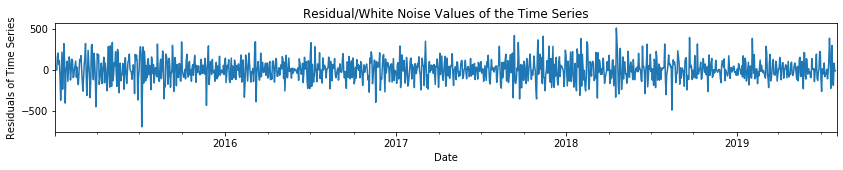

In [39]:
decomp_resid = decomposition.resid
ax = decomp_resid.plot(figsize=(14,2))

ax.set_xlabel('Date')
ax.set_ylabel('Residuals of Time Series')
ax.set_title('Residual/White Noise Values of the Time Series')
plt.show()

In [75]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    #pd.rolling_mean(timeseries, window=12)
    rolstd =  pd.Series(timeseries).rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [76]:
decomp_resid.dropna(inplace=True)


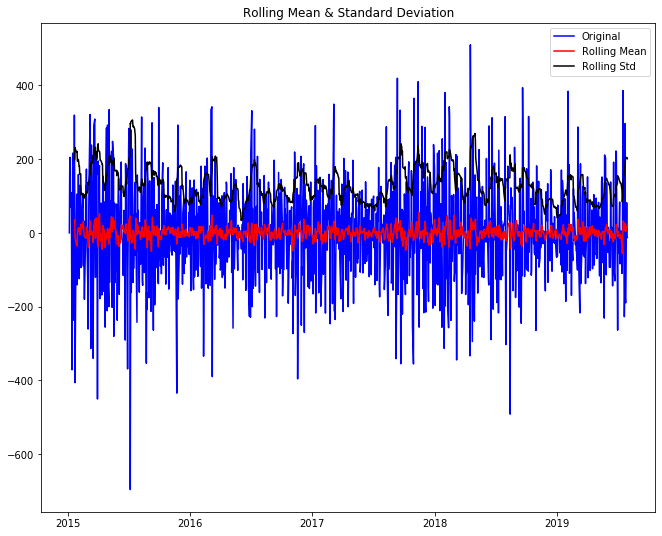

Results of Dickey-Fuller Test:
Test Statistic                -1.405554e+01
p-value                        3.122129e-26
#Lags Used                     1.700000e+01
Number of Observations Used    1.174000e+03
Critical Value (1%)           -3.435932e+00
Critical Value (5%)           -2.864005e+00
Critical Value (10%)          -2.568082e+00
dtype: float64


In [77]:
test_stationarity(decomp_resid)

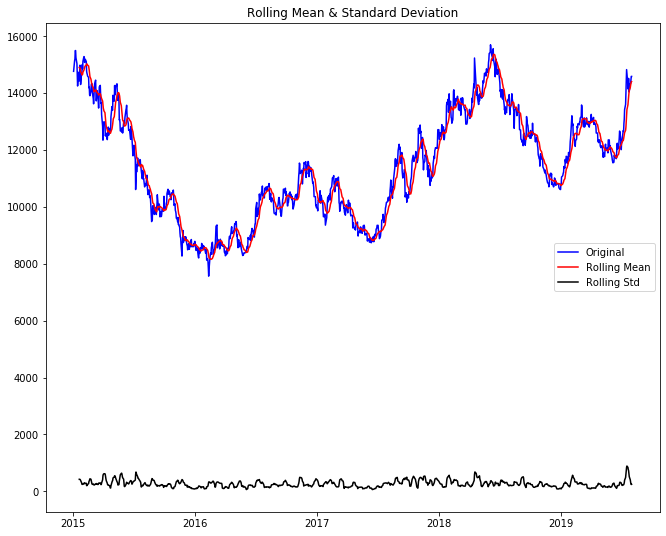

Results of Dickey-Fuller Test:
Test Statistic                   -1.971200
p-value                           0.299342
#Lags Used                        0.000000
Number of Observations Used    1195.000000
Critical Value (1%)              -3.435834
Critical Value (5%)              -2.863962
Critical Value (10%)             -2.568059
dtype: float64


In [78]:
test_stationarity(nickel_weekly)

## Making Time Series Stationary
As seen on: 
https://campus.datacamp.com/courses/forecasting-using-arima-models-in-python/chapter-1-arma-models?ex=5

The most common test for identifying if time series data is stationary is the Dicky-Fuller Test - (Null hypothesis is that time series data is non-stationary on 


In [26]:
results = adfuller(nickel)

print(results)

(-1.9711999348352705, 0.2993419051235137, 0, 1195, {'1%': -3.4358340188169882, '5%': -2.8639616494853217, '10%': -2.5680593310691338}, 15853.188858095957)


### Results Analysis - Does Not Pass the Dicky Fuller Test: 

First number is the **test statistic**: 
- The more negative it is means the more likely it is to be stationary

Second number is the p-value 
- If p-value is small, then we can reject the null hypothesis that the data is non-stationary and accept the alternative hypothesis that the data is stationary

Last values (dictionary values)
- If we wanted a p-value of 0.05 or below, we would need a test statistic of less than -2.86396

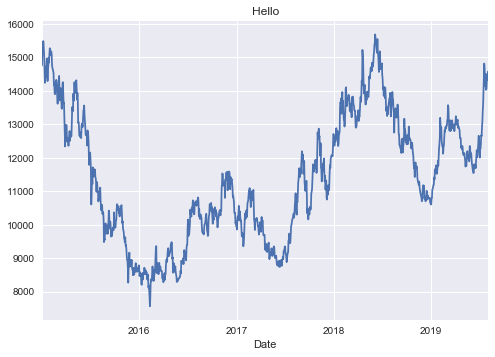

In [19]:
nickel.plot()
plt.style.use('seaborn')
plt.title("Hello")
plt.show()


## Transforming the Data into Stationary Form Before Modeling

Common way is to take it's difference (subtract the previous value)


Other methods for reshaping into stationary are: 
- Taking the log (np.log(nickel))
- Taking the square root (np.sqrt(nickel))
- Taking the proportional change (nickel.shift(1)/nickel)

In [16]:
nickel_stationary = nickel.diff().dropna()

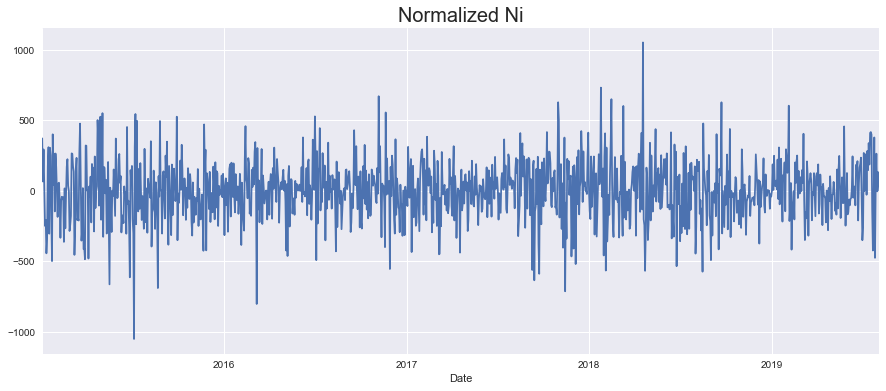

In [20]:
nickel_stationary.plot(figsize=(15,6))
plt.style.use('seaborn')
plt.title("Normalized Ni", fontsize=20)
plt.show()


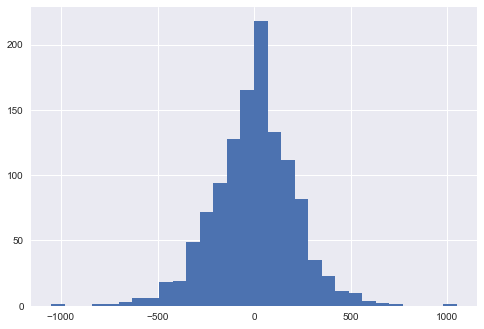

In [234]:
nickel_stationary.hist(bins=30)
plt.show()

In [177]:
results = adfuller(nickel_stationary)

print(results)

(-35.76480686193036, 0.0, 0, 1194, {'1%': -3.4358386217286885, '5%': -2.8639636801920956, '10%': -2.5680604125597277}, 15843.385342382324)


## Modeling
AR, MA, and ARMA Models
https://campus.datacamp.com/courses/forecasting-using-arima-models-in-python/chapter-1-arma-models?ex=9

Using p lags

In [54]:
p = 2
q = 2


ar_model = ARMA(nickel_stationary, order = (1,0))
ma_model = ARMA(nickel_stationary, order = (0, 1))

In [55]:
ar_results = ar_model.fit()
print(ar_results.summary())



                              ARMA Model Results                              
Dep. Variable:      LME Ni cash price   No. Observations:                 1196
Model:                     ARMA(1, 0)   Log Likelihood               -8097.643
Method:                       css-mle   S.D. of innovations            210.552
Date:                Mon, 07 Oct 2019   AIC                          16201.286
Time:                        18:41:12   BIC                          16216.546
Sample:                    01-02-2015   HQIC                         16207.035
                         - 08-02-2019                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1.222e+04   1121.664     10.891      0.000       1e+04    1.44e+04
ar.L1.LME Ni cash price     0.9951      0.003    346.818      0.000       0.989       1.001


In [241]:
ma_results = ma_model.fit()

print(ma_results.summary())

                              ARMA Model Results                              
Dep. Variable:      LME Ni cash price   No. Observations:                 1195
Model:                     ARMA(0, 1)   Log Likelihood               -8089.239
Method:                       css-mle   S.D. of innovations            210.671
Date:                Sun, 22 Sep 2019   AIC                          16184.478
Time:                        13:53:38   BIC                          16199.736
Sample:                    01-05-2015   HQIC                         16190.227
                         - 08-02-2019                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.1536      5.879     -0.026      0.979     -11.676      11.369
ma.L1.LME Ni cash price    -0.0354      0.029     -1.199      0.231      -0.093       0.022


### SARIMAX models can do everything ARMA models can do

https://campus.datacamp.com/courses/forecasting-using-arima-models-in-python/chapter-2-fitting-the-future?ex=5

In [245]:
sar_model = SARIMAX(y, order=(p,0,q), trend='c')

/Users/ckato/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [246]:
# Make predictions for the last 25 values
results = sar_model.fit()

# Makes in-sample prediction
# start defines how many steps back to begin the forecast 
forecast = results.get_prediction(start = -25)

# Forecast mean
mean_forecast = forecast.predicted_mean

In [257]:
mean_forecast

2019-07-01    12613.287086
2019-07-02    12279.971012
2019-07-03    12022.028690
2019-07-04    12267.302145
2019-07-05    12263.006882
2019-07-08    12416.449900
2019-07-09    12661.016268
2019-07-10    12643.045592
2019-07-11    12918.605083
2019-07-12    13057.610140
2019-07-15    13394.813471
2019-07-16    13575.355132
2019-07-17    13983.288749
2019-07-18    14387.112634
2019-07-19    14788.246578
2019-07-22    14666.840813
2019-07-23    14267.791072
2019-07-24    14134.665922
2019-07-25    14487.416012
2019-07-26    14031.255252
2019-07-29    14070.108690
2019-07-30    14300.692502
2019-07-31    14309.841588
2019-08-01    14439.505422
2019-08-02    14561.194787
Freq: B, dtype: float64

In [248]:
confidence_intervals = forecast.conf_int()
print(confidence_intervals)

            lower LME Ni cash price  upper LME Ni cash price
2019-07-01             12201.986708             13024.587463
2019-07-02             11868.670634             12691.271389
2019-07-03             11610.728312             12433.329067
2019-07-04             11856.001767             12678.602522
2019-07-05             11851.706504             12674.307259
2019-07-08             12005.149523             12827.750277
2019-07-09             12249.715891             13072.316646
2019-07-10             12231.745215             13054.345970
2019-07-11             12507.304705             13329.905460
2019-07-12             12646.309762             13468.910517
2019-07-15             12983.513094             13806.113848
2019-07-16             13164.054755             13986.655510
2019-07-17             13571.988372             14394.589127
2019-07-18             13975.812257             14798.413012
2019-07-19             14376.946200             15199.546955
2019-07-22             1

## Plotting Results


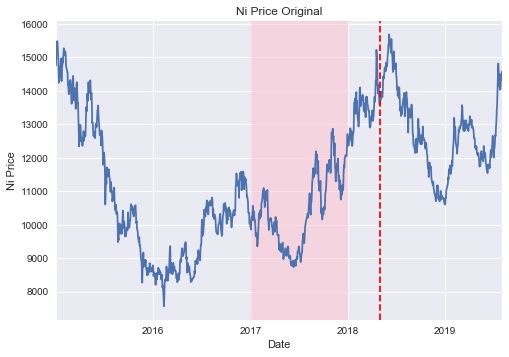

In [282]:
ax = nickel.plot()
ax.set_title("Ni Price Original")

ax.set_xlabel("Date")
ax.set_ylabel("Ni Price")

ax.axvline('2018-5-1', color='red', linestyle='--')


ax.axvspan('2017-1-1', '2018-1-1', color='pink', alpha=.5)
plt.show()

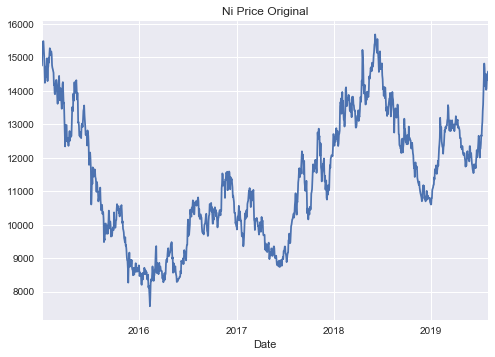

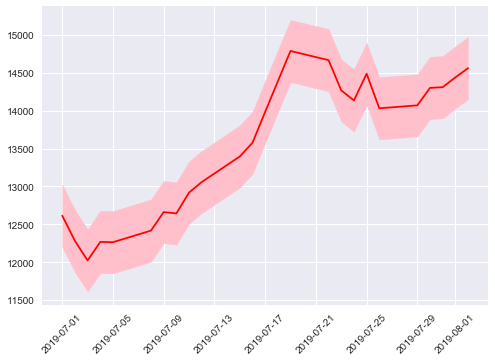

In [273]:
dates = mean_forecast.index
lower_limits = confidence_intervals.iloc[:,0]
upper_limits = confidence_intervals.iloc[:,1]



nickel.plot()
plt.title("Ni Price Original")

plt.figure()

# Plot prediction

plt.plot(dates, mean_forecast.values, 
        color = 'red',
        label='forecast')
plt.xticks(rotation=45)
# Share uncertainty area
plt.fill_between(dates,lower_limits, upper_limits, color='pink')

plt.show()

In [255]:
len(mean_forecast.values)

25

## Making Dynamic Predictions (ie, one or more steps ahead predictions)



## Interpolation
https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/predicting-time-series-data?ex=5



In [25]:
missing = nickel.isna()

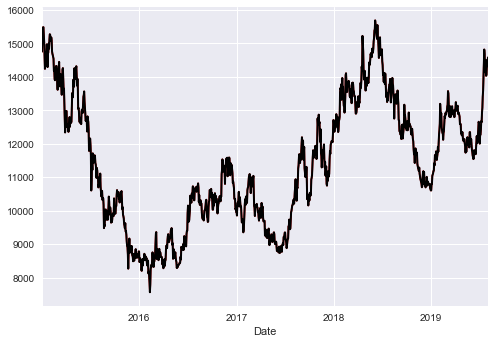

In [27]:
nickel_interp = nickel.interpolate('linear')

ax = nickel_interp.plot(c='r')
nickel.plot(c='k', ax=ax, lw=2)

In [28]:
# Standardizing variance of data

In [33]:
# from https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/predicting-time-series-data?ex=5

def percent_change(values):
    previous_values = values[:-1]
    last_value = values[-1]
    
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change



AttributeError: 'NoneType' object has no attribute 'set_visable'

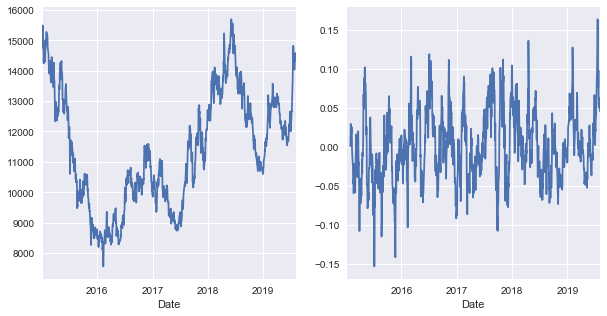

In [39]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
ax = nickel.plot(ax=axs[0])

ax = nickel.rolling(window=20).aggregate(percent_change).plot(ax=axs[1])
ax.legend_.set_visable(False)


In [ ]:
# https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/predicting-time-series-data?ex=5

In [40]:
nickel_perc_change = percent_change(nickel)

AttributeError: 'numpy.float64' object has no attribute 'plot'

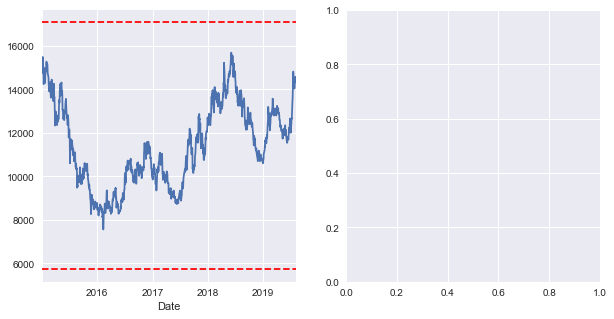

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for data, ax in zip([nickel, nickel_perc_change], axs):
    
    this_mean = data.mean()
    this_std = data.std()
    
    data.plot(ax=ax)
    ax.axhline(this_mean + this_std*3, ls='--', c='r')
    ax.axhline(this_mean - this_std*3, ls='--', c='r')
    

In [47]:
## BACK TO ARIMA MODELING: 

for p in range(3):
    for q in range(3):
        try:
            
            model = SARIMAX(nickel, order=(p, 0, q))
            results = model.fit()
            
            print(p, q, results.aic, results.bic)
        except:
            print(p, q, None, None)
            


C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


0 0 25773.525875394622 25778.612613329133
0 1 24242.326750385317 24252.50022625434


C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


0 2 23087.938813038134 23103.199026841667
1 0 16205.859853400863 16216.033329269885


C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


1 1 16206.845745659597 16222.105959463128
1 2 16208.437387685744 16228.784339423786


C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


2 0 16206.853394723097 16222.113608526628


C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


2 1 16207.783184620905 16228.130136358946


C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


2 2 16209.447359754195 16234.881049426747
